# By Mingcheng Xu
# This notebook contains 5 models:

1. Linear regression with word length, word frequency and pre-trained Glove embeddings

2. LSTM classification

3. LSTM classification with Glove

4. LSTM that predicts complexity as a float number

5. LSTM that predicts a float number, with Glove

In [1]:
!pip install syllables

In [2]:
import re
import pickle
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import spacy
from collections import Counter
from copy import deepcopy
import math

import torchtext.vocab

import string
import re

import nltk
from nltk.corpus import stopwords

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

import syllables

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# the paths; change when necessary
TRAIN_RAW = "/content/gdrive/My Drive/Colab Notebooks/CS505FinalProject/lcp_single_train.tsv"
TEST_RAW = "/content/gdrive/My Drive/Colab Notebooks/CS505FinalProject/lcp_single_test.tsv"
TRAIN = "/content/gdrive/My Drive/Colab Notebooks/CS505FinalProject/lcp_single_train_cleaned.tsv"
TEST = "/content/gdrive/My Drive/Colab Notebooks/CS505FinalProject/lcp_single_test_cleaned.tsv"

In [5]:
# read the datasets
# train
with open(TRAIN_RAW, 'r') as f:
  data = f.read()

# need to remove " from the string, otherwise parsing will have problems because some quotas are not closed 
data = data.replace('"', '')

with open(TRAIN, 'w') as f:
  f.write(data)

df = pd.read_csv(TRAIN, sep='\t')

# test
with open(TEST_RAW, 'r') as f:
  data = f.read()

data = data.replace('"', '')

with open(TEST, 'w') as f:
  f.write(data)

test = pd.read_csv(TEST, sep='\t')

In [6]:
# take a look
pd.set_option('display.max_colwidth', None) # show the whole sentence
df.head()

,id,corpus,sentence,token,complexity
0,3ZLW647WALVGE8EBR50EGUBPU4P32A,bible,"Behold, there came up out of the river seven cattle, sleek and fat, and they fed in the marsh grass.",river,0.000000
1,34R0BODSP1ZBN3DVY8J8XSIY551E5C,bible,"I am a fellow bondservant with you and with your brothers, the prophets, and with those who keep the words of this book.",brothers,0.000000
2,3S1WOPCJFGTJU2SGNAN2Y213N6WJE3,bible,"The man, the lord of the land, said to us, 'By this I will know that you are honest men: leave one of your brothers with me, and take grain for the famine of your houses, and go your way.",brothers,0.050000
3,3BFNCI9LYKQN09BHXHH9CLSX5KP738,bible,"Shimei had sixteen sons and six daughters; but his brothers didn't have many children, neither did all their family multiply like the children of Judah.",brothers,0.150000
4,3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2,bible,He has put my brothers far from me.,brothers,0.263889


In [7]:
test.head()

,id,corpus,sentence,token,complexity
0,3K8CQCU3KE19US5SN890DFPK3SANWR,bible,"But he, beckoning to them with his hand to be silent, declared to them how the Lord had brought him out of the prison.",hand,0.000000
1,3Q2T3FD0ON86LCI41NJYV3PN0BW3MV,bible,"If I forget you, Jerusalem, let my right hand forget its skill.",hand,0.197368
2,3ULIZ0H1VA5C32JJMKOTQ8Z4GUS51B,bible,"the ten sons of Haman the son of Hammedatha, the Jew's enemy, but they didn't lay their hand on the plunder.",hand,0.200000
3,3BFF0DJK8XCEIOT30ZLBPPSRMZQTSD,bible,"Let your hand be lifted up above your adversaries, and let all of your enemies be cut off.",hand,0.267857
4,3QREJ3J433XSBS8QMHAICCR0BQ1LKR,bible,"Abimelech chased him, and he fled before him, and many fell wounded, even to the entrance of the gate.",entrance,0.000000


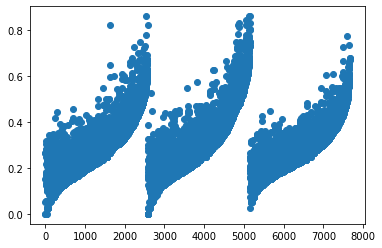

In [8]:
# the distribution of the complexities in training set
look_complexities = df['complexity'].to_list()
x_axis = [i for i in range(len(look_complexities))]
plt.scatter(x_axis, look_complexities)
plt.show()

#Try linear regression first.

In [9]:
def create_weights_matrix(vocab, dimension=100):
  """ create a matrix containing vectors for each word in Glove """
  matrix_len = len(vocab)
  weights_matrix = np.zeros((matrix_len, dimension))

  for i, word in enumerate(vocab):
      try: 
          weights_matrix[i] = glove[word]
      except KeyError:
          weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, )) # initialize a random vector
  #return torch.from_numpy(weights_matrix) # a tensor
  return weights_matrix

In [10]:
# use the Glove 6B 100d
cache_dir = "/content/gdrive/My Drive/Colab Notebooks/data"
# glove = vocab.pretrained_aliases["glove.6B.100d"](cache=cache_dir)
glove = torchtext.vocab.GloVe(name='6B', dim=100, cache=cache_dir)

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# get all the non-unique tokens for prediction
tokens = df['token'].dropna().to_list() # nan should be in the last row which is empty
tokens = [token.lower() for token in tokens] # lowercase
print(len(tokens))

# check if all tokens are in Glove
for token in tokens:
  if token not in glove.stoi:
    print("Token Not Found: ")
    print(token)

7659
Token Not Found: 
perverseness
Token Not Found: 
perverseness
Token Not Found: 
perverseness
Token Not Found: 
housetops
Token Not Found: 
slanderers
Token Not Found: 
plowmen
Token Not Found: 
dainties
Token Not Found: 
dainties
Token Not Found: 
dainties
Token Not Found: 
dainties
Token Not Found: 
dainties
Token Not Found: 
dunghill
Token Not Found: 
carotids
Token Not Found: 
tace


In [13]:
# create a dataframe for linear regression
train_df = pd.DataFrame(tokens, columns =['token'])

# add back complexity
train_df['complexity'] = df['complexity']

# word length
train_df['word_length'] = train_df['token'].map(lambda x: len(x))

# punctuations
punc = string.punctuation

# stop words
stop_words = set(stopwords.words('english')) 

# word frequency
# tokenize the whole curpus
temp = df['sentence'].to_list()
texts = []
for sent in temp:
  sent = sent.lower()
  sent = ''.join([c for c in sent if c not in punc])
  words = [word for word in sent.split(' ') if (word.isalpha() and word not in stop_words)]
  texts += words
# count frequency
count_word_frequency = Counter(texts)
train_df['word_frequency'] = train_df['token'].map(lambda x: count_word_frequency[x])

# syllables
train_df['syllable'] = train_df['token'].map(lambda x: syllables.estimate(x))

train_df.head()

,token,complexity,word_length,word_frequency,syllable
0,river,0.000000,5,26,2
1,brothers,0.000000,8,36,2
2,brothers,0.050000,8,36,2
3,brothers,0.150000,8,36,2
4,brothers,0.263889,8,36,2


In [14]:
# create the weight matrix
weights_matrix = create_weights_matrix(tokens)
print(weights_matrix.shape)

# combine
weights_matrix_df = pd.DataFrame(weights_matrix)

train_df_combined = pd.concat([train_df, weights_matrix_df], axis=1)
train_df_combined.head()

(7659, 100)


,token,complexity,word_length,word_frequency,syllable,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,river,0.000000,5,26,2,-0.33249,-0.56631,0.54255,-0.11869,0.531290,-0.49381,0.64114,0.85982,0.39633,-1.53950,-0.30613,0.97267,-0.31192,-0.10311,0.359510,-0.60023,0.909830,-0.959540,-0.55375,0.082818,0.26711,0.64645,-0.098556,0.539240,-0.21810,-0.13430,-1.80700,-0.14879,0.39006,-0.62883,-0.38825,0.31925,0.77853,-0.60273,0.063585,...,-0.53185,0.72585,0.36811,0.19494,0.64276,0.81460,0.26748,-0.39275,0.425950,0.11699,0.21063,-0.061747,0.79298,-0.45978,0.85176,-0.36726,0.11816,0.504160,-0.065352,0.69672,0.37525,0.92586,-0.83036,-0.087948,-0.49715,0.21411,-0.82838,-0.85912,0.61576,1.18800,-0.30745,-1.20090,-1.70970,0.51400,-1.01590,0.55555,-1.03850,-0.69940,1.050600,0.24051
1,brothers,0.000000,8,36,2,0.85968,-0.39038,-0.62678,-0.55279,0.097012,0.00658,-0.65021,-0.58272,-1.27630,0.11251,0.78504,0.16027,0.38327,0.62672,-0.017462,-0.36443,0.062441,0.039266,-0.47318,0.547680,0.42916,-0.25516,0.100900,0.041618,-0.14579,0.15174,-0.54301,-0.29787,0.36268,0.89550,0.65319,0.40141,0.03668,-0.34313,-0.102040,...,0.65085,0.97366,0.36997,-0.58266,0.58389,-0.62574,-0.24252,1.37500,-0.042651,0.16398,-0.53462,0.552750,-0.58019,-0.78386,-0.18787,-0.20305,0.11506,-0.089296,-0.766080,0.04339,0.50251,0.73799,0.23388,0.200380,-0.93906,-0.33974,-0.56534,-0.95945,-0.14597,-0.35173,-0.40463,-0.32671,0.24982,-0.27804,-0.99877,-0.39367,-0.30087,-0.24623,0.006483,-0.21982
2,brothers,0.050000,8,36,2,0.85968,-0.39038,-0.62678,-0.55279,0.097012,0.00658,-0.65021,-0.58272,-1.27630,0.11251,0.78504,0.16027,0.38327,0.62672,-0.017462,-0.36443,0.062441,0.039266,-0.47318,0.547680,0.42916,-0.25516,0.100900,0.041618,-0.14579,0.15174,-0.54301,-0.29787,0.36268,0.89550,0.65319,0.40141,0.03668,-0.34313,-0.102040,...,0.65085,0.97366,0.36997,-0.58266,0.58389,-0.62574,-0.24252,1.37500,-0.042651,0.16398,-0.53462,0.552750,-0.58019,-0.78386,-0.18787,-0.20305,0.11506,-0.089296,-0.766080,0.04339,0.50251,0.73799,0.23388,0.200380,-0.93906,-0.33974,-0.56534,-0.95945,-0.14597,-0.35173,-0.40463,-0.32671,0.24982,-0.27804,-0.99877,-0.39367,-0.30087,-0.24623,0.006483,-0.21982
3,brothers,0.150000,8,36,2,0.85968,-0.39038,-0.62678,-0.55279,0.097012,0.00658,-0.65021,-0.58272,-1.27630,0.11251,0.78504,0.16027,0.38327,0.62672,-0.017462,-0.36443,0.062441,0.039266,-0.47318,0.547680,0.42916,-0.25516,0.100900,0.041618,-0.14579,0.15174,-0.54301,-0.29787,0.36268,0.89550,0.65319,0.40141,0.03668,-0.34313,-0.102040,...,0.65085,0.97366,0.36997,-0.58266,0.58389,-0.62574,-0.24252,1.37500,-0.042651,0.16398,-0.53462,0.552750,-0.58019,-0.78386,-0.18787,-0.20305,0.11506,-0.089296,-0.766080,0.04339,0.50251,0.73799,0.23388,0.200380,-0.93906,-0.33974,-0.56534,-0.95945,-0.14597,-0.35173,-0.40463,-0.32671,0.24982,-0.27804,-0.99877,-0.39367,-0.30087,-0.24623,0.006483,-0.21982
4,brothers,0.263889,8,36,2,0.85968,-0.39038,-0.62678,-0.55279,0.097012,0.00658,-0.65021,-0.58272,-1.27630,0.11251,0.78504,0.16027,0.38327,0.62672,-0.017462,-0.36443,0.062441,0.039266,-0.47318,0.547680,0.42916,-0.25516,0.100900,0.041618,-0.14579,0.15174,-0.54301,-0.29787,0.36268,0.89550,0.65319,0.40141,0.03668,-0.34313,-0.102040,...,0.65085,0.97366,0.36997,-0.58266,0.58389,-0.62574,-0.24252,1.37500,-0.042651,0.16398,-0.53462,0.552750,-0.58019,-0.78386,-0.18787,-0.20305,0.11506,-0.089296,-0.766080,0.04339,0.50251,0.73799,0.23388,0.200380,-0.93906,-0.33974,-0.56534,-0.95945,-0.14597,-0.35173,-0.40463,-0.32671,0.24982,-0.27804,-0.99877,-0.39367,-0.30087,-0.24623,0.006483,-0.21982


In [15]:
# get data for training
X_train = train_df_combined.drop(columns=['token', 'complexity'])
Y_train = train_df_combined['complexity']

In [16]:
# train linear regression
lr = LinearRegression().fit(X_train, Y_train)

In [17]:
# predict
Y_pred = lr.predict(X_train)

In [18]:
# train loss (average absolute loss)
num = len(Y_pred)
losses = []
for i in range(num):
  loss = abs(Y_pred[i] - Y_train[i])
  losses.append(loss)
abl = sum(losses) / num
print("average training absolute loss is " + str(abl))

average training absolute loss is 0.07232029925149179


In [19]:
# on test
test_tokens = test['token'].dropna().to_list()
test_tokens = [token.lower() for token in test_tokens] # lowercase
print(len(test_tokens))

# create a dataframe for linear regression
test_df = pd.DataFrame(test_tokens, columns =['token'])

# add back complexity
test_df['complexity'] = test['complexity']

# word length
test_df['word_length'] = test_df['token'].map(lambda x: len(x))

# word frequency
# tokenize the whole curpus
temp = test['sentence'].to_list()
texts = []
for sent in temp:
  sent = sent.lower()
  sent = ''.join([c for c in sent if c not in punc])
  words = [word for word in sent.split(' ') if (word.isalpha() and word not in stop_words)]
  texts += words
# count frequency
count = Counter(texts)
test_df['word_frequency'] = test_df['token'].map(lambda x: count[x])

# syllables
test_df['syllable'] = test_df['token'].map(lambda x: syllables.estimate(x))

# create the weight matrix
weights_matrix = create_weights_matrix(test_tokens)
print(weights_matrix.shape)

# combine
weights_matrix_df = pd.DataFrame(weights_matrix)
test_df_combined = pd.concat([test_df, weights_matrix_df], axis=1)
test_df_combined.head()

917
(917, 100)


,token,complexity,word_length,word_frequency,syllable,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,hand,0.000000,4,19,1,-0.24945,0.37033,-0.058334,-0.25367,0.18709,0.81760,-0.045494,0.072066,-0.059079,-0.053018,-0.15681,-0.18621,0.786770,0.56263,0.023693,0.241160,0.034775,0.117630,-0.15757,-0.39749,0.210680,-0.14618,0.014017,-0.22373,0.54225,0.47379,-0.62683,-0.38803,0.27510,-0.54687,0.49211,0.052715,-0.12911,0.2554,-0.005657,...,0.64518,0.76559,-0.22193,0.39305,0.13373,-0.17641,0.36222,0.47786,-0.43591,-0.13363,-0.13145,0.206730,0.37353,-0.70188,0.53225,0.103710,-0.70940,0.24331,-0.15523,0.20785,1.19970,-0.036297,-0.79044,-0.27794,-1.40760,-0.363180,0.40219,0.17401,-0.080981,-0.40688,-0.044007,-0.14964,0.39369,-0.014732,-0.41309,-0.061931,-0.088387,-0.230930,0.93931,0.091475
1,hand,0.197368,4,19,1,-0.24945,0.37033,-0.058334,-0.25367,0.18709,0.81760,-0.045494,0.072066,-0.059079,-0.053018,-0.15681,-0.18621,0.786770,0.56263,0.023693,0.241160,0.034775,0.117630,-0.15757,-0.39749,0.210680,-0.14618,0.014017,-0.22373,0.54225,0.47379,-0.62683,-0.38803,0.27510,-0.54687,0.49211,0.052715,-0.12911,0.2554,-0.005657,...,0.64518,0.76559,-0.22193,0.39305,0.13373,-0.17641,0.36222,0.47786,-0.43591,-0.13363,-0.13145,0.206730,0.37353,-0.70188,0.53225,0.103710,-0.70940,0.24331,-0.15523,0.20785,1.19970,-0.036297,-0.79044,-0.27794,-1.40760,-0.363180,0.40219,0.17401,-0.080981,-0.40688,-0.044007,-0.14964,0.39369,-0.014732,-0.41309,-0.061931,-0.088387,-0.230930,0.93931,0.091475
2,hand,0.200000,4,19,1,-0.24945,0.37033,-0.058334,-0.25367,0.18709,0.81760,-0.045494,0.072066,-0.059079,-0.053018,-0.15681,-0.18621,0.786770,0.56263,0.023693,0.241160,0.034775,0.117630,-0.15757,-0.39749,0.210680,-0.14618,0.014017,-0.22373,0.54225,0.47379,-0.62683,-0.38803,0.27510,-0.54687,0.49211,0.052715,-0.12911,0.2554,-0.005657,...,0.64518,0.76559,-0.22193,0.39305,0.13373,-0.17641,0.36222,0.47786,-0.43591,-0.13363,-0.13145,0.206730,0.37353,-0.70188,0.53225,0.103710,-0.70940,0.24331,-0.15523,0.20785,1.19970,-0.036297,-0.79044,-0.27794,-1.40760,-0.363180,0.40219,0.17401,-0.080981,-0.40688,-0.044007,-0.14964,0.39369,-0.014732,-0.41309,-0.061931,-0.088387,-0.230930,0.93931,0.091475
3,hand,0.267857,4,19,1,-0.24945,0.37033,-0.058334,-0.25367,0.18709,0.81760,-0.045494,0.072066,-0.059079,-0.053018,-0.15681,-0.18621,0.786770,0.56263,0.023693,0.241160,0.034775,0.117630,-0.15757,-0.39749,0.210680,-0.14618,0.014017,-0.22373,0.54225,0.47379,-0.62683,-0.38803,0.27510,-0.54687,0.49211,0.052715,-0.12911,0.2554,-0.005657,...,0.64518,0.76559,-0.22193,0.39305,0.13373,-0.17641,0.36222,0.47786,-0.43591,-0.13363,-0.13145,0.206730,0.37353,-0.70188,0.53225,0.103710,-0.70940,0.24331,-0.15523,0.20785,1.19970,-0.036297,-0.79044,-0.27794,-1.40760,-0.363180,0.40219,0.17401,-0.080981,-0.40688,-0.044007,-0.14964,0.39369,-0.014732,-0.41309,-0.061931,-0.088387,-0.230930,0.93931,0.091475
4,entrance,0.000000,8,2,3,0.25776,0.10680,-0.162650,0.42335,0.19078,0.46283,-0.959150,0.931740,0.471610,0.390770,0.54734,0.41967,0.086822,0.53954,0.354970,-0.028346,0.427080,0.036569,-0.49700,-0.49543,-0.031232,-0.30298,-0.417180,-0.78459,0.70473,-0.59741,-0.33173,-0.38813,0.17189,-0.78565,-0.17219,-0.140190,0.61492,0.5713,0.751090,...,-0.60393,0.47454,0.80912,0.81709,-0.12876,-0.39310,0.17656,-0.29797,-0.32614,-0.26522,-0.37006,-0.016956,0.92268,-0.71606,-0.38524,-0.085737,0.68111,0.32080,0.45870,-0.82737,0.22932,0.314500,-0.21221,-0.65293,-0.31427,-0.037493,0.16126,-0.46719,0.630660,0.26426,0.527780,-0.34505,0.06620,0.722400,-0.11057,-0.005771,-0.059336,0.013272,0.97305,0.454050


In [20]:
# get data for test
X_test = test_df_combined.drop(columns=['token', 'complexity'])
Y_test = test_df_combined['complexity']

# predict
Y_pred = lr.predict(X_test)

# test loss (average absolute loss)
num = len(Y_pred)
losses = []
for i in range(num):
  loss = abs(Y_pred[i] - Y_test[i])
  losses.append(loss)
abl = sum(losses) / num
print("average test absolute loss is " + str(abl))

average test absolute loss is 0.0728225436388098


#LSTM classification with 5 classes

In [21]:
# tokenize sentences

def tokenize(sent, token, punc, stop_words):
  """ lowercase, padded, remove stopwords and punctuations """
  # lowercase
  sent = sent.lower()
  # remove punctuation and stopwords
  sent = ''.join([c for c in sent if c not in punc]) 
  tokens = [word for word in sent.split(' ') if (word.isalpha() and word not in stop_words)]
  # pad
  tokens.insert(0, '<s>')
  tokens.append('</s>')
  # pad the token with special symbols
  for i in range(len(tokens)):
    if tokens[i] == token:
      tokens.insert(i, '_START')
      tokens.insert(i+2, '_END')
      break

  return tokens

def get_complexity_level(n):
  """ map complexity to corresponding level """
  # 1: 0, 2: 0:25, 3: 0:5, 4: 0:75, 5: 1
  # To use cross entropy, each label has to minus 1
  if n <= 0:
    return 0
  elif n <= 0.25:
    return 1
  elif n <= 0.5:
    return 2
  elif n <= 0.75:
    return 3 
  return 4

def preprocess(df):
  data = df[['sentence', 'token', 'complexity']]
  data['tokenized_sentence'] = data.apply(lambda row: tokenize(row['sentence'], row['token'], punc, stop_words), axis=1)
  data['complexity'] = data['complexity'].map(lambda x: get_complexity_level(x))
  data = data.drop(columns=['sentence'])
  return data

train_data = preprocess(df)
test_data = preprocess(test)

train_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,token,complexity,tokenized_sentence
0,river,0,"[<s>, behold, came, _START, river, _END, seven, cattle, sleek, fat, fed, marsh, grass, </s>]"
1,brothers,0,"[<s>, fellow, bondservant, _START, brothers, _END, prophets, keep, words, book, </s>]"
2,brothers,1,"[<s>, man, lord, land, said, us, know, honest, men, leave, one, _START, brothers, _END, take, grain, famine, houses, go, way, </s>]"
3,brothers,1,"[<s>, shimei, sixteen, sons, six, daughters, _START, brothers, _END, didnt, many, children, neither, family, multiply, like, children, judah, </s>]"
4,brothers,2,"[<s>, put, _START, brothers, _END, far, </s>]"


In [22]:
# take a look at the number of instances for different complexities
temp1 = train_data[train_data['complexity'] == 0]
temp2 = train_data[train_data['complexity'] == 1]
temp3 = train_data[train_data['complexity'] == 2]
temp4 = train_data[train_data['complexity'] == 3]
temp5 = train_data[train_data['complexity'] == 4]

print("1: ")
print(temp1.shape)
print("2: ")
print(temp2.shape)
print("3: ")
print(temp3.shape)
print("4: ")
print(temp4.shape)
print("5: ")
print(temp5.shape)

# there are very few 1 and 5 in the training set

1: 
(18, 3)
2: 
(3251, 3)
3: 
(3755, 3)
4: 
(617, 3)
5: 
(21, 3)


In [23]:
# convert words to index for training and testing purpose
sentences = train_data['tokenized_sentence'].to_list()
temp = []
for sent in sentences:
  temp += sent
temp = set(temp)
# for words that are unknown
temp.add('_UNKNOWN') 
temp.add('_PADDING')
print(len(temp))

# need to pad sentences to the same length
lengths = [len(sent) for sent in sentences]
pad_length = max(lengths)
print(pad_length)

# construct dictionaries
word2index = {}
index2word = {}
for i, word in enumerate(temp):
  word2index[word] = i
  index2word[i] = word

def word_to_index(sentence):
  # sentence: a list of strings
  r = []
  for word in sentence:
    if word in word2index:
      r.append(word2index[word])
    else:
      r.append(word2index['_UNKNOWN'])
  diff = pad_length - len(sentence)
  pad_index = word2index['_PADDING']
  for i in range(diff):
    r.append(pad_index)
  return r

train_data['number_sentence'] = train_data['tokenized_sentence'].map(lambda sent: word_to_index(sent))
test_data['number_sentence'] = test_data['tokenized_sentence'].map(lambda sent: word_to_index(sent))

train_data = train_data.drop(columns=['tokenized_sentence'])
test_data = test_data.drop(columns=['tokenized_sentence'])

train_data.head()

14826
118


,token,complexity,number_sentence
0,river,0,"[12519, 10247, 7219, 13783, 13286, 14669, 1919, 13564, 9596, 6190, 6534, 1805, 8725, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"
1,brothers,0,"[12519, 1320, 1563, 13783, 1976, 14669, 5114, 7041, 5972, 2765, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"
2,brothers,1,"[12519, 9006, 9305, 4797, 10670, 5002, 604, 7164, 2595, 4708, 4233, 13783, 1976, 14669, 7246, 2194, 7736, 12769, 7670, 8125, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"
3,brothers,1,"[12519, 4683, 5221, 2810, 3235, 10720, 13783, 1976, 14669, 5712, 12226, 7183, 12823, 13593, 6496, 1378, 7183, 9567, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"
4,brothers,2,"[12519, 2253, 13783, 1976, 14669, 9750, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"


In [24]:
# do a simple check
print(df.shape)
print(train_data.shape)
print(test_data.shape)
print(len(word2index.keys()))
print(len(index2word.keys()))

(7662, 5)
(7662, 3)
(917, 3)
14826
14826


In [25]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [26]:
# prepare the batch loader
train_sentences = np.array(train_data['number_sentence'].to_list())
train_labels = np.array(train_data['complexity'].to_list())
test_sentences = np.array(test_data['number_sentence'].to_list())
test_labels = np.array(test_data['complexity'].to_list())

training = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
testing = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 128

train_loader = DataLoader(training, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(testing, shuffle=True, batch_size=batch_size, drop_last=True)

In [27]:
def create_weights_matrix_tensor(target_vocab, dimension=100):
  """ create a matrix containing vectors for each word, adding word length, frequency and syllables """
  matrix_len = len(target_vocab)
  weights_matrix = np.zeros((matrix_len, dimension + 3))

  for i, word in enumerate(target_vocab):
      # initialize a random vector
      weights_matrix[i] = np.concatenate( (np.random.normal(scale=0.6, size=(dimension, )), np.array([len(word), count_word_frequency[word], syllables.estimate(word)])), axis=0 ) # concatenate 2 1d arrays
  return torch.from_numpy(weights_matrix) # must be a tensor!!

def create_emb_layer(weights_matrix, non_trainable=False):
  """ an embedding layer """
  num_embeddings, embedding_dim = weights_matrix.size()
  emb_layer = nn.Embedding(num_embeddings, embedding_dim)
  emb_layer.load_state_dict({'weight': weights_matrix})
  if non_trainable:
    emb_layer.weight.requires_grad = False

  return emb_layer, num_embeddings, embedding_dim

In [28]:
# the LSTM class
class ComplexityNet(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_dim, n_layers, weights_matrix, drop_prob=0.5):
        super(ComplexityNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)       
        out = self.fc(lstm_out[:, -1, :])      
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [29]:
# some parameters
vocab_size = len(word2index) + 1
output_size = 5
# embedding dim is not needed because it can be obtained from weights_matrix
hidden_dim = 512
n_layers = 2
weights_matrix = create_weights_matrix_tensor(word2index.keys())

model = ComplexityNet(vocab_size, output_size, hidden_dim, n_layers, weights_matrix)
model.to(device)
print(model)

lr=0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100
counter = 0
print_every = 256
clip = 5

ComplexityNet(
  (embedding): Embedding(14826, 103)
  (lstm): LSTM(103, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)


In [30]:
# training
model.train()
for i in range(epochs):
  h = model.init_hidden(batch_size)
    
  for inputs, labels in train_loader:
    counter += 1
    h = tuple([e.data for e in h])
    inputs, labels = inputs.to(device), labels.to(device)
    model.zero_grad()
    output, h = model(inputs, h)
    # cross entropy for multiple classes
    # output is of shape 64 * 5 while labels is of shape 64
    loss = criterion(output, labels) 
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    if counter%print_every == 0:
      print("Epoch: {}/{}...".format(i+1, epochs), "Step: {}...".format(counter), "Loss: {:.6f}...".format(loss.item()))

Epoch: 5/100... Step: 256... Loss: 1.021214...
Epoch: 9/100... Step: 512... Loss: 1.053857...
Epoch: 14/100... Step: 768... Loss: 0.951657...
Epoch: 18/100... Step: 1024... Loss: 1.055660...
Epoch: 22/100... Step: 1280... Loss: 0.936611...
Epoch: 27/100... Step: 1536... Loss: 0.986246...
Epoch: 31/100... Step: 1792... Loss: 1.048536...
Epoch: 35/100... Step: 2048... Loss: 1.049713...
Epoch: 40/100... Step: 2304... Loss: 1.035149...
Epoch: 44/100... Step: 2560... Loss: 0.917061...
Epoch: 48/100... Step: 2816... Loss: 0.918828...
Epoch: 53/100... Step: 3072... Loss: 0.895716...
Epoch: 57/100... Step: 3328... Loss: 1.014937...
Epoch: 61/100... Step: 3584... Loss: 1.017656...
Epoch: 66/100... Step: 3840... Loss: 0.964298...
Epoch: 70/100... Step: 4096... Loss: 1.026663...
Epoch: 74/100... Step: 4352... Loss: 0.934233...
Epoch: 79/100... Step: 4608... Loss: 1.028960...
Epoch: 83/100... Step: 4864... Loss: 1.163527...
Epoch: 87/100... Step: 5120... Loss: 0.964568...
Epoch: 92/100... Step: 53

In [31]:
# save the model
torch.save(model.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/CS505FinalProject/LSTM_classification_no_Glove.pt")

In [32]:
test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    fetched_labels = labels.data.tolist()
    fetched_output = output.squeeze().data.tolist()
    #print(len(fetched_labels)) # 32
    #print(len(fetched_output[0])) # 5

    # absolute mean average; different from the cross entropy used in training
    denominator = len(output)
    for i in range(denominator):
      diff = abs( fetched_labels[i] - ( fetched_output[i].index( max(fetched_output[i])) ) )
      if diff == 0:
        num_correct += 1
      test_losses.append(diff)

print(test_losses)        
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 0, 2, 0, 1, 0, 3, 2, 0, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 

#LSTM classification with 5 classes and pre-trained Glove embedding

In [33]:
# restart the loader
train_sentences = np.array(train_data['number_sentence'].to_list())
train_labels = np.array(train_data['complexity'].to_list())
test_sentences = np.array(test_data['number_sentence'].to_list())
test_labels = np.array(test_data['complexity'].to_list())

training = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
testing = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 128

train_loader = DataLoader(training, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(testing, shuffle=True, batch_size=batch_size, drop_last=True)

In [34]:
def create_weights_matrix_tensor(target_vocab, dimension=100):
  """ create a matrix containing vectors for each word in glove, adding word length, frequency and syllables"""
  matrix_len = len(target_vocab)
  weights_matrix = np.zeros((matrix_len, dimension + 3))

  for i, word in enumerate(target_vocab):
      try: 
          weights_matrix[i] = torch.cat( (glove[word], torch.Tensor([len(word), count_word_frequency[word], syllables.estimate(word)])) ) 
      except KeyError:
          # initialize a random vector
          weights_matrix[i] = np.concatenate( (np.random.normal(scale=0.6, size=(dimension, )), np.array([len(word), count_word_frequency[word], syllables.estimate(word)])), axis=0 ) # concatenate 2 1d arrays
      
  return torch.from_numpy(weights_matrix) # must be a tensor!!

def create_emb_layer(weights_matrix, non_trainable=False):
  """ an embedding layer """
  num_embeddings, embedding_dim = weights_matrix.size()
  emb_layer = nn.Embedding(num_embeddings, embedding_dim)
  emb_layer.load_state_dict({'weight': weights_matrix})
  if non_trainable:
    emb_layer.weight.requires_grad = False

  return emb_layer, num_embeddings, embedding_dim

In [35]:
# The model; inherits from the previous model
class ComplexityNetGlove(ComplexityNet):
    def __init__(self, vocab_size, output_size, hidden_dim, n_layers, weights_matrix, drop_prob=0.5):
        super(ComplexityNetGlove, self).__init__(vocab_size, output_size, hidden_dim, n_layers, weights_matrix)
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True) # use the Glove
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size)

In [36]:
vocab_size = len(word2index) + 1
output_size = 5

hidden_dim = 512
n_layers = 2
weights_matrix = create_weights_matrix_tensor(word2index.keys())

model = ComplexityNetGlove(vocab_size, output_size, hidden_dim, n_layers, weights_matrix)
model.to(device)
print(model)

lr=0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100
counter = 0
print_every = 256
clip = 5

ComplexityNetGlove(
  (embedding): Embedding(14826, 103)
  (lstm): LSTM(103, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)


In [37]:
# training
model.train()
for i in range(epochs):
  h = model.init_hidden(batch_size)
    
  for inputs, labels in train_loader:
    counter += 1
    h = tuple([e.data for e in h])
    inputs, labels = inputs.to(device), labels.to(device)
    model.zero_grad()
    output, h = model(inputs, h)
    # cross entropy for multiple classes
    # output is of shape 64 * 5 while labels is of shape 64
    loss = criterion(output, labels) 
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    if counter%print_every == 0:
      print("Epoch: {}/{}...".format(i+1, epochs), "Step: {}...".format(counter), "Loss: {:.6f}...".format(loss.item()))

Epoch: 5/100... Step: 256... Loss: 1.045902...
Epoch: 9/100... Step: 512... Loss: 1.043418...
Epoch: 14/100... Step: 768... Loss: 1.035378...
Epoch: 18/100... Step: 1024... Loss: 0.948163...
Epoch: 22/100... Step: 1280... Loss: 1.068360...
Epoch: 27/100... Step: 1536... Loss: 0.955419...
Epoch: 31/100... Step: 1792... Loss: 1.003160...
Epoch: 35/100... Step: 2048... Loss: 0.992437...
Epoch: 40/100... Step: 2304... Loss: 0.964292...
Epoch: 44/100... Step: 2560... Loss: 1.016639...
Epoch: 48/100... Step: 2816... Loss: 0.876871...
Epoch: 53/100... Step: 3072... Loss: 0.955015...
Epoch: 57/100... Step: 3328... Loss: 0.941595...
Epoch: 61/100... Step: 3584... Loss: 0.974338...
Epoch: 66/100... Step: 3840... Loss: 0.925720...
Epoch: 70/100... Step: 4096... Loss: 1.007498...
Epoch: 74/100... Step: 4352... Loss: 0.994998...
Epoch: 79/100... Step: 4608... Loss: 0.876456...
Epoch: 83/100... Step: 4864... Loss: 0.951598...
Epoch: 87/100... Step: 5120... Loss: 1.006770...
Epoch: 92/100... Step: 53

In [38]:
# save the model
torch.save(model.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/CS505FinalProject/LSTM_classification_with_Glove.pt")

In [39]:
test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    fetched_labels = labels.data.tolist()
    fetched_output = output.squeeze().data.tolist()
    #print(len(fetched_labels)) # 32
    #print(len(fetched_output[0])) # 5

    # absolute mean average
    denominator = len(output)
    for i in range(denominator):
      diff = abs( fetched_labels[i] - ( fetched_output[i].index( max(fetched_output[i])) ) )
      if diff == 0:
        num_correct += 1
      test_losses.append(diff)

print(test_losses)        
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

[0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 

# LSTM with continuous complexities

In [40]:
# tokenize sentences

def tokenize(sent, token, punc, stop_words):
  """ lowercase, padded, remove stopwords and punctuations """
  # lowercase
  sent = sent.lower()
  # remove punctuation and stopwords
  sent = ''.join([c for c in sent if c not in punc]) 
  tokens = [word for word in sent.split(' ') if (word.isalpha() and word not in stop_words)]
  # pad
  tokens.insert(0, '<s>')
  tokens.append('</s>')
  # pad the token with special symbols
  for i in range(len(tokens)):
    if tokens[i] == token:
      tokens.insert(i, '_START')
      tokens.insert(i+2, '_END')
      break

  return tokens

def preprocess(df):
  data = df[['sentence', 'token', 'complexity']]
  data['tokenized_sentence'] = data.apply(lambda row: tokenize(row['sentence'], row['token'], punc, stop_words), axis=1)
  data = data.drop(columns=['sentence'])
  return data

train_data = preprocess(df)
test_data = preprocess(test)

train_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,token,complexity,tokenized_sentence
0,river,0.000000,"[<s>, behold, came, _START, river, _END, seven, cattle, sleek, fat, fed, marsh, grass, </s>]"
1,brothers,0.000000,"[<s>, fellow, bondservant, _START, brothers, _END, prophets, keep, words, book, </s>]"
2,brothers,0.050000,"[<s>, man, lord, land, said, us, know, honest, men, leave, one, _START, brothers, _END, take, grain, famine, houses, go, way, </s>]"
3,brothers,0.150000,"[<s>, shimei, sixteen, sons, six, daughters, _START, brothers, _END, didnt, many, children, neither, family, multiply, like, children, judah, </s>]"
4,brothers,0.263889,"[<s>, put, _START, brothers, _END, far, </s>]"


In [41]:
# convert words to index for training and testing purpose
sentences = train_data['tokenized_sentence'].to_list()
temp = []
for sent in sentences:
  temp += sent
temp = set(temp)
# for words that are unknown
temp.add('_UNKNOWN') 
temp.add('_PADDING')
print(len(temp))

# need to pad sentences to the same length
lengths = [len(sent) for sent in sentences]
pad_length = max(lengths)
print(pad_length)

# construct dictionaries
word2index = {}
index2word = {}
for i, word in enumerate(temp):
  word2index[word] = i
  index2word[i] = word

def word_to_index(sentence):
  # sentence: a list of strings
  r = []
  for word in sentence:
    if word in word2index:
      r.append(word2index[word])
    else:
      r.append(word2index['_UNKNOWN'])
  diff = pad_length - len(sentence)
  pad_index = word2index['_PADDING']
  for i in range(diff):
    r.append(pad_index)
  return r

train_data['number_sentence'] = train_data['tokenized_sentence'].map(lambda sent: word_to_index(sent))
test_data['number_sentence'] = test_data['tokenized_sentence'].map(lambda sent: word_to_index(sent))

train_data = train_data.drop(columns=['tokenized_sentence'])
test_data = test_data.drop(columns=['tokenized_sentence'])

train_data.head()

14826
118


,token,complexity,number_sentence
0,river,0.000000,"[12519, 10247, 7219, 13783, 13286, 14669, 1919, 13564, 9596, 6190, 6534, 1805, 8725, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"
1,brothers,0.000000,"[12519, 1320, 1563, 13783, 1976, 14669, 5114, 7041, 5972, 2765, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"
2,brothers,0.050000,"[12519, 9006, 9305, 4797, 10670, 5002, 604, 7164, 2595, 4708, 4233, 13783, 1976, 14669, 7246, 2194, 7736, 12769, 7670, 8125, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"
3,brothers,0.150000,"[12519, 4683, 5221, 2810, 3235, 10720, 13783, 1976, 14669, 5712, 12226, 7183, 12823, 13593, 6496, 1378, 7183, 9567, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"
4,brothers,0.263889,"[12519, 2253, 13783, 1976, 14669, 9750, 2993, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, 10288, ...]"


In [42]:
train_sentences = np.array(train_data['number_sentence'].to_list())
train_labels = np.array(train_data['complexity'].to_list())
test_sentences = np.array(test_data['number_sentence'].to_list())
test_labels = np.array(test_data['complexity'].to_list())

training = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
testing = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 128

train_loader = DataLoader(training, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(testing, shuffle=True, batch_size=batch_size, drop_last=True)

In [43]:
def create_weights_matrix_tensor(target_vocab, dimension=100):
  """ create a matrix containing vectors for each word, adding word length, frequency and syllables """
  matrix_len = len(target_vocab)
  weights_matrix = np.zeros((matrix_len, dimension + 3))

  for i, word in enumerate(target_vocab):
      # initialize a random vector
      weights_matrix[i] = np.concatenate( (np.random.normal(scale=0.6, size=(dimension, )), np.array([len(word), count_word_frequency[word], syllables.estimate(word)])), axis=0 ) # concatenate 2 1d arrays
  return torch.from_numpy(weights_matrix) # must be a tensor!!

def create_emb_layer(weights_matrix, non_trainable=False):
  """ an embedding layer """
  num_embeddings, embedding_dim = weights_matrix.size()
  emb_layer = nn.Embedding(num_embeddings, embedding_dim)
  emb_layer.load_state_dict({'weight': weights_matrix})
  if non_trainable:
    emb_layer.weight.requires_grad = False

  return emb_layer, num_embeddings, embedding_dim

In [44]:
# the LSTM class
class ComplexityNet(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_dim, n_layers, weights_matrix, drop_prob=0.5):
        super(ComplexityNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)       
        out = self.fc(lstm_out[:, -1, :])      
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [45]:
# some parameters
vocab_size = len(word2index) + 1
output_size = 1

hidden_dim = 512
n_layers = 2
weights_matrix = create_weights_matrix_tensor(word2index.keys())

model = ComplexityNet(vocab_size, output_size, hidden_dim, n_layers, weights_matrix)
model.to(device)
print(model)

lr=0.01
criterion = nn.L1Loss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100
counter = 0
print_every = 256
clip = 5

ComplexityNet(
  (embedding): Embedding(14826, 103)
  (lstm): LSTM(103, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


In [46]:
# training
model.train()
for i in range(epochs):
  h = model.init_hidden(batch_size)
    
  for inputs, labels in train_loader:
    counter += 1
    h = tuple([e.data for e in h])
    inputs, labels = inputs.to(device), labels.to(device)
    model.zero_grad()
    output, h = model(inputs, h)
    # cross entropy for multiple classes
    # output is of shape 64 * 5 while labels is of shape 64
    loss = criterion(output, labels) 
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    if counter%print_every == 0:
      print("Epoch: {}/{}...".format(i+1, epochs), "Step: {}...".format(counter), "Loss: {:.6f}...".format(loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 5/100... Step: 256... Loss: 0.110809...
Epoch: 9/100... Step: 512... Loss: 0.112754...
Epoch: 14/100... Step: 768... Loss: 0.087854...
Epoch: 18/100... Step: 1024... Loss: 0.104705...
Epoch: 22/100... Step: 1280... Loss: 0.106671...
Epoch: 27/100... Step: 1536... Loss: 0.095664...
Epoch: 31/100... Step: 1792... Loss: 0.116617...
Epoch: 35/100... Step: 2048... Loss: 0.115502...
Epoch: 40/100... Step: 2304... Loss: 0.123669...
Epoch: 44/100... Step: 2560... Loss: 0.093843...
Epoch: 48/100... Step: 2816... Loss: 0.083815...
Epoch: 53/100... Step: 3072... Loss: 0.095055...
Epoch: 57/100... Step: 3328... Loss: 0.108419...
Epoch: 61/100... Step: 3584... Loss: 0.097134...
Epoch: 66/100... Step: 3840... Loss: 0.106839...
Epoch: 70/100... Step: 4096... Loss: 0.110869...
Epoch: 74/100... Step: 4352... Loss: 0.103946...
Epoch: 79/100... Step: 4608... Loss: 0.106590...
Epoch: 83/100... Step: 4864... Loss: 0.104640...
Epoch: 87/100... Step: 5120... Loss: 0.099286...
Epoch: 92/100... Step: 53

In [47]:
# save the model
torch.save(model.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/CS505FinalProject/LSTM_continuous_no_Glove.pt")

In [48]:
test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    fetched_labels = labels.data.tolist()
    fetched_output = output.squeeze().data.tolist()
    #print(len(fetched_labels)) # 32
    #print(len(fetched_output[0])) # 5

    # absolute mean average; different from the cross entropy used in training
    denominator = len(output)
    for i in range(denominator):
      diff = abs( fetched_labels[i] - fetched_output[i] )
      if diff <= 0.05: # a difference that is small
        num_correct += 1
      test_losses.append(diff)

print(test_losses)        
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

[0.08369353413581848, 0.020473132530848148, 0.09063797858026287, 0.0055685341358184814, 0.09472294590052438, 0.07255646586418152, 0.07404456110227675, 0.39547313253084815, 0.035082423024707377, 0.29825091030862594, 0.2141005835112404, 0.014520751578467217, 0.057753834285234174, 0.4788064658641815, 0.18786020080248517, 0.2211935341358185, 0.006487651782877357, 0.016306465864181496, 0.028806465864181563, 0.006584243641959309, 0.0343620214197371, 0.08786020080248516, 0.11213979919751482, 0.0055685341358184814, 0.03762999527594624, 0.05060529884170084, 0.02119353413581848, 0.02119353413581848, 0.05452686746915181, 0.1954731325308482, 0.07255646586418152, 0.18190781985010418, 0.02119353413581848, 0.14619353413581848, 0.12166360872132442, 0.12011081369026844, 0.008218230570063934, 0.10380646586418152, 0.17880646586418153, 0.022924112923005002, 0.02119353413581848, 0.046193534135818476, 0.06806853413581848, 0.14057117174653444, 0.1176953547530703, 0.08174764233476972, 0.03786020080248517, 0.0

#LSTM with continuous complexities and with pre-trained Glove embeddings

In [49]:
# restart the loader
train_sentences = np.array(train_data['number_sentence'].to_list())
train_labels = np.array(train_data['complexity'].to_list())
test_sentences = np.array(test_data['number_sentence'].to_list())
test_labels = np.array(test_data['complexity'].to_list())

training = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
testing = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 128

train_loader = DataLoader(training, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(testing, shuffle=True, batch_size=batch_size, drop_last=True)

In [50]:
def create_weights_matrix_tensor(target_vocab, dimension=100):
  """ create a matrix containing vectors for each word in glove, adding word length, frequency and syllables """
  matrix_len = len(target_vocab)
  weights_matrix = np.zeros((matrix_len, dimension + 3))

  for i, word in enumerate(target_vocab):
      try: 
          weights_matrix[i] = torch.cat( (glove[word], torch.Tensor([len(word), count_word_frequency[word], syllables.estimate(word)])) ) 
      except KeyError:
          # initialize a random vector
          weights_matrix[i] = np.concatenate( (np.random.normal(scale=0.6, size=(dimension, )), np.array([len(word), count_word_frequency[word], syllables.estimate(word)])), axis=0 ) # concatenate 2 1d arrays
  return torch.from_numpy(weights_matrix) # must be a tensor!!

def create_emb_layer(weights_matrix, non_trainable=False):
  """ an embedding layer """
  num_embeddings, embedding_dim = weights_matrix.size()
  emb_layer = nn.Embedding(num_embeddings, embedding_dim)
  emb_layer.load_state_dict({'weight': weights_matrix})
  if non_trainable:
    emb_layer.weight.requires_grad = False

  return emb_layer, num_embeddings, embedding_dim

In [51]:
# The model; inherits from the previous model
class ComplexityNetGlove(ComplexityNet):
    def __init__(self, vocab_size, output_size, hidden_dim, n_layers, weights_matrix, drop_prob=0.5):
        super(ComplexityNetGlove, self).__init__(vocab_size, output_size, hidden_dim, n_layers, weights_matrix)
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True) # use the Glove
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size)

In [52]:
vocab_size = len(word2index) + 1
output_size = 1

hidden_dim = 512
n_layers = 2
weights_matrix = create_weights_matrix_tensor(word2index.keys())

model = ComplexityNetGlove(vocab_size, output_size, hidden_dim, n_layers, weights_matrix)
model.to(device)
print(model)

lr=0.01
criterion = nn.L1Loss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100
counter = 0
print_every = 256
clip = 5

ComplexityNetGlove(
  (embedding): Embedding(14826, 103)
  (lstm): LSTM(103, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


In [53]:
# training
model.train()
for i in range(epochs):
  h = model.init_hidden(batch_size)
    
  for inputs, labels in train_loader:
    counter += 1
    h = tuple([e.data for e in h])
    inputs, labels = inputs.to(device), labels.to(device)
    model.zero_grad()
    output, h = model(inputs, h)
    # cross entropy for multiple classes
    # output is of shape 64 * 5 while labels is of shape 64
    loss = criterion(output, labels) 
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    if counter%print_every == 0:
      print("Epoch: {}/{}...".format(i+1, epochs), "Step: {}...".format(counter), "Loss: {:.6f}...".format(loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 5/100... Step: 256... Loss: 0.099750...
Epoch: 9/100... Step: 512... Loss: 0.106811...
Epoch: 14/100... Step: 768... Loss: 0.096551...
Epoch: 18/100... Step: 1024... Loss: 0.103706...
Epoch: 22/100... Step: 1280... Loss: 0.094218...
Epoch: 27/100... Step: 1536... Loss: 0.106070...
Epoch: 31/100... Step: 1792... Loss: 0.100953...
Epoch: 35/100... Step: 2048... Loss: 0.104744...
Epoch: 40/100... Step: 2304... Loss: 0.099212...
Epoch: 44/100... Step: 2560... Loss: 0.097646...
Epoch: 48/100... Step: 2816... Loss: 0.110612...
Epoch: 53/100... Step: 3072... Loss: 0.106337...
Epoch: 57/100... Step: 3328... Loss: 0.106714...
Epoch: 61/100... Step: 3584... Loss: 0.086385...
Epoch: 66/100... Step: 3840... Loss: 0.109730...
Epoch: 70/100... Step: 4096... Loss: 0.102852...
Epoch: 74/100... Step: 4352... Loss: 0.100007...
Epoch: 79/100... Step: 4608... Loss: 0.107177...
Epoch: 83/100... Step: 4864... Loss: 0.115883...
Epoch: 87/100... Step: 5120... Loss: 0.109049...
Epoch: 92/100... Step: 53

In [54]:
# save the model
torch.save(model.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/CS505FinalProject/LSTM_continuous_with_Glove.pt")

In [55]:
test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    fetched_labels = labels.data.tolist()
    fetched_output = output.squeeze().data.tolist()
    #print(len(fetched_labels)) # 32
    #print(len(fetched_output[0])) # 5

    # absolute mean average
    denominator = len(output)
    for i in range(denominator):
      diff = abs( fetched_labels[i] - fetched_output[i] )
      if diff <= 0.05: # a difference that is small
        num_correct += 1
      test_losses.append(diff)

print(test_losses)        
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

[0.2586483889155917, 0.009465352577321617, 0.028092833360036207, 0.1263384771974463, 0.044759500026702925, 0.21142616669336955, 0.06774049997329712, 0.18225950002670288, 0.4947595000267029, 0.03649049997329712, 0.03784919562547101, 0.005240499973297119, 0.03649049997329712, 0.038877147085526365, 0.0719071666399638, 0.02309764283043997, 0.0052405595779418945, 0.09475950002670286, 0.005240529775619507, 0.11142625610033674, 0.14809764283043997, 0.02600950002670288, 0.04163450002670288, 0.16663450002670288, 0.03301827775107491, 0.1052404999732971, 0.0052404701709747314, 0.11142616669336958, 0.09091337598287136, 0.04370203843483553, 0.05725950002670288, 0.05524049997329711, 0.3161880714552743, 0.2552404999732971, 0.09274049997329714, 0.09899047017097473, 0.11975950002670288, 0.08299479414434996, 0.03649047017097473, 0.1572596490383148, 0.007917394763544972, 0.07809289296468103, 0.08857383330663043, 0.04690716663996383, 0.026009559631347656, 0.27600958943367004, 0.018569023836226717, 0.14475

In [56]:
print("THE END")

THE END
